<a href="https://colab.research.google.com/github/Abtin-Ghorbani/mastrs_project_XAI_pneumonia_detection/blob/main/masters_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dawnload dataset from Kaggle**

In [1]:
from google.colab import drive
import os
import shutil
import kagglehub
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q Kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!mkdir dataset
!unzip -q chest-xray-pneumonia.zip -d dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:28<00:00, 222MB/s]
100% 2.29G/2.29G [00:28<00:00, 86.8MB/s]


In [3]:
import os

base_dir = '/content/dataset/chest_xray'
print(os.listdir(base_dir))#folder names

['test', 'train', 'chest_xray', '__MACOSX', 'val']


# **task 1 data preproccessing**

In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

In [19]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    validation_split=0.2,  # 20 of the data will be used for validation
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
for images, labels in train_ds.take(1):  # فقط یک batch می‌گیریم
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels:", labels.numpy())  # چاپ لیبل‌های واقعی

Images shape: (32, 224, 224, 3)
Labels shape: (32, 1)
Labels: [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]


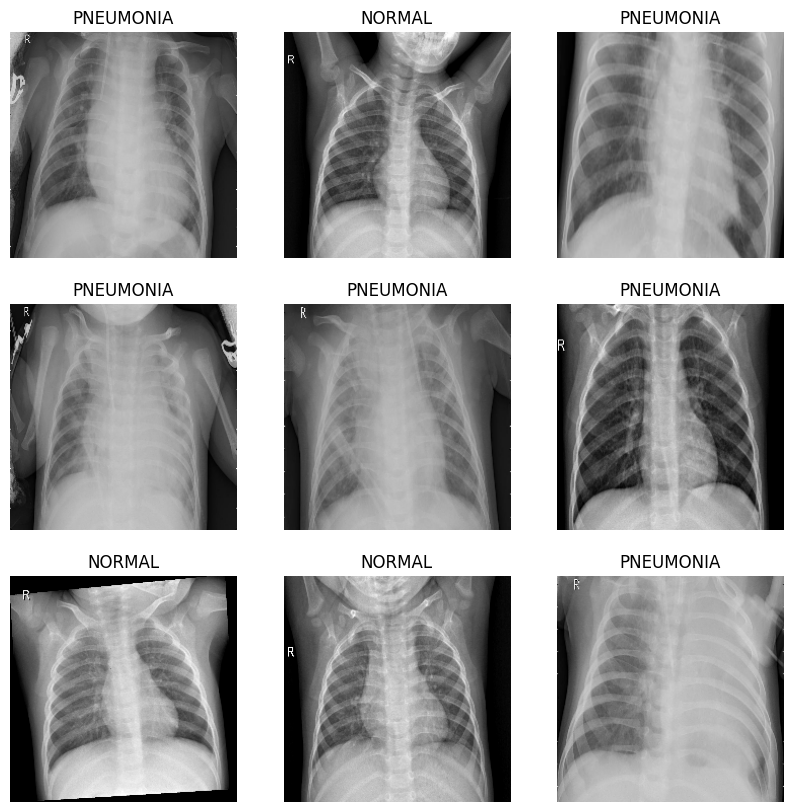

In [8]:
import matplotlib.pyplot as plt

class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# **Normalization**

In [9]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [22]:
def preprocess(image, label):
    image = preprocess_input(image)  # between mobile net [-1, 1]
    return image, label
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# **buld and Train CNN model for pneumonia classification**

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

In [24]:
# Load the base MobileNetV2 model without the top classification layers
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False# Freeze the base model so its weights do not change during training

# **buil model **

In [25]:
# Build the full model on top of MobileNetV2
model = models.Sequential([
    base_model,   # Pretrained convolutional base
    layers.GlobalAveragePooling2D(),  # Reduce feature map to vector (1280)
    layers.Dropout(0.2),   #to prevent overfitting
    layers.Dense(1, activation='sigmoid') #  Pneumonia or normal
])

# **compile the model **

In [26]:
# Compile the model with optimizer, loss, and metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',                                # For binary classification
    metrics=['accuracy']
)

# **train model with images**

In [27]:
# Train the model using early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.7115 - loss: 0.5613 - val_accuracy: 0.8054 - val_loss: 0.3653
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - accuracy: 0.8069 - loss: 0.4044 - val_accuracy: 0.8965 - val_loss: 0.2820
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8803 - loss: 0.3068 - val_accuracy: 0.9396 - val_loss: 0.2346
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9148 - loss: 0.2607 - val_accuracy: 0.9559 - val_loss: 0.2019
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9213 - loss: 0.2348 - val_accuracy: 0.9626 - val_loss: 0.1807
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9293 - loss: 0.2093 - val_accuracy: 0.9616 - val_loss: 0.1662
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9419 - loss: 0.1921 - val_accuracy: 0.9626 - val_loss: 0.1537
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9410 - loss: 0.1824 - val_

# **evaluate model**

In [28]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.8108 - loss: 0.3744
Test Accuracy: 0.8061


# **fine tune model**

In [29]:
base_model.trainable = True

#unfreeze the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),  # Smaller LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint(
    "mobilenetv2_best_val_loss.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    mode="min",
    verbose=1
)

In [36]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9989 - loss: 0.0174
Epoch 1: val_loss improved from inf to 0.04843, saving model to mobilenetv2_best_val_loss.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - accuracy: 0.9989 - loss: 0.0174 - val_accuracy: 0.9837 - val_loss: 0.0484
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9988 - loss: 0.0137
Epoch 2: val_loss did not improve from 0.04843
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.9988 - loss: 0.0137 - val_accuracy: 0.9818 - val_loss: 0.0494
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9998 - loss: 0.0108
Epoch 3: val_loss did not improve from 0.04843
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9998 - loss: 0.0108 - val_accuracy: 0.9827 - val_loss: 0.0512
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [32]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy after fine tuning: {test_acc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8713 - loss: 0.3828
Test Accuracy after fine tuning: 0.8526
